In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt

figsize = (16,4)
plt.rcParams['figure.figsize'] = figsize
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_parquet("/kaggle/input/stock-history/stock-history-features.parquet")
df.insert(9, "close", df.pop("close"))

In [2]:
df

,stock,day_of_week,day,month,year,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,close
0,TSLA,1,4,1,2022,391.56,11.83,391.56,11.83,383.20
1,TSLA,2,5,1,2022,381.94,18.64,381.94,18.64,362.71
2,TSLA,3,6,1,2022,375.18,20.36,375.18,20.36,354.90
3,TSLA,4,7,1,2022,368.61,22.95,368.61,22.95,342.32
4,TSLA,0,10,1,2022,365.96,21.53,365.96,21.53,352.71
...,...,...,...,...,...,...,...,...,...,...
1876,GOOG,3,27,6,2024,181.86,4.11,179.79,3.64,186.86
1877,GOOG,4,28,6,2024,182.86,3.36,180.34,3.57,183.42
1878,GOOG,0,1,7,2024,183.82,2.49,180.90,3.56,184.49
1879,GOOG,1,2,7,2024,184.73,2.10,181.50,3.77,186.61


In [32]:
class StockData():
    def __init__(self, stock, data, look_back=30, test_size=0.2):
        self.stock = stock
        self.data = data.query(f"stock == '{stock}'").copy()
        self.data.drop("stock", axis=1, inplace=True)
        self.look_back = look_back
        self.test_size = test_size
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
        self.X = self.data.values
        self.y = self.data['close'].values.reshape(-1,1)
        
    def create_sequences(self, data):
        input_data = []
        target_data = []
        for i in range(len(data[0]) - self.look_back):
            input_seq = data[0][i:i+self.look_back]
            input_data.append(input_seq)

            target_value = data[1][i+self.look_back]
            target_data.append(target_value)
        return np.array(input_data), np.array(target_data)
        
    def scale_split_sequence(self):
        X_scaled = self.x_scaler.fit_transform(self.X)
        y_scaled = self.y_scaler.fit_transform(self.y)
        
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                            test_size=self.test_size, 
                                                            shuffle=False)
        
        X_train, y_train = self.create_sequences([X_train, y_train])
        X_test, y_test = self.create_sequences([X_test, y_test])
        
        return X_train, X_test, y_train, y_test

In [31]:
TSLA = StockData("TSLA", df)
AAPL = StockData("AAPL", df)
GOOG = StockData("GOOG", df)

In [ ]:
X_train, X_test, y_train, y_test = TSLA.scale_split_sequence()

In [55]:
# def tsla_model_builder(hp):
#     model = Sequential()
    
#     hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
#     hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
#     hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=500, step=50)
    
#     model.add(GRU(hp_layer_1, activation=hp_activation, input_shape=(window_size, X_train.shape[2])))
#     model.add(Dense(1))
#     model.compile(optimizer=hp_optimizer, loss='mse')
    
#     return model

# tsla_tuner = kt.Hyperband(tsla_model_builder,
#                     objective='val_loss',
#                     max_epochs=20,
#                     factor=3,
#                     directory='dir',
#                     project_name='x')

# stop_early = EarlyStopping(monitor='val_loss', patience=3)

# tsla_tuner.search(X_train, y_train, epochs=50,  validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 03s]
val_loss: 0.0037381493020802736

Best val_loss So Far: 0.0010501752840355039
Total elapsed time: 00h 02m 23s


In [65]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# tsla_model = tuner.hypermodel.build(best_hps)
# tsla_history = tsla_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[stop_early])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1045

W0000 00:00:1720651863.133082    4114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1004

W0000 00:00:1720651863.948253    4112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.0970 - val_loss: 0.0050
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148 - val_loss: 0.0040
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 0.

In [93]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        # Tune the number of GRU layers
        for i in range(hp.Int("num_gru_layers", 1, 3)):
            model.add(
                GRU(
                    units=hp.Int(f"gru_units_{i}", min_value=25, max_value=200, step=25),
                    return_sequences=True if i < hp.Int("num_gru_layers", 1, 3) - 1 else False,
                    input_shape=(window_size, X_train.shape[2]) if i == 0 else None
                )
            )
        model.add(Dense(1))  # Output layer for predicting the closing price

        # Tune the optimizer and learning rate
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

        model.compile(
            optimizer=opt,
            loss='mse'
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
        )
    
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [94]:
# Instantiate the HyperModel
hypermodel = MyHyperModel()

# Define the tuner
tuner = kt.RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='dir',
    project_name='y'
)

# Perform the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 20 Complete [00h 00m 12s]
val_loss: 0.003660856746137142

Best val_loss So Far: 0.0008868305012583733
Total elapsed time: 00h 04m 03s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 100)        │        33,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 175)        │       145,425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        34,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,826 (831.35 KB)

 Trainable params: 212,826 (831.35 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# model = Sequential()
# model.add(GRU(50, input_shape=(window_size, X_train.shape[2])))
# model.add(Dense(1))  # Output layer for predicting the closing price
# model.compile(optimizer='adam', loss='mse')
# model.summary()
# model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, callbacks=[stop_early])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 50)             │         9,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,201 (35.94 KB)

 Trainable params: 9,201 (35.94 KB)

 Non-trainable params: 0 (0.00 B)

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


In [95]:
predictions = best_model.predict(X_test)
predictions_inv = y_scaler.inverse_transform(predictions)
y_test_inv = y_scaler.inverse_transform(y_test)

def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f} USD.".format(rmse))
    
evaluate_model(y_test_inv, predictions_inv)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
The root mean squared error is 8.58 USD.


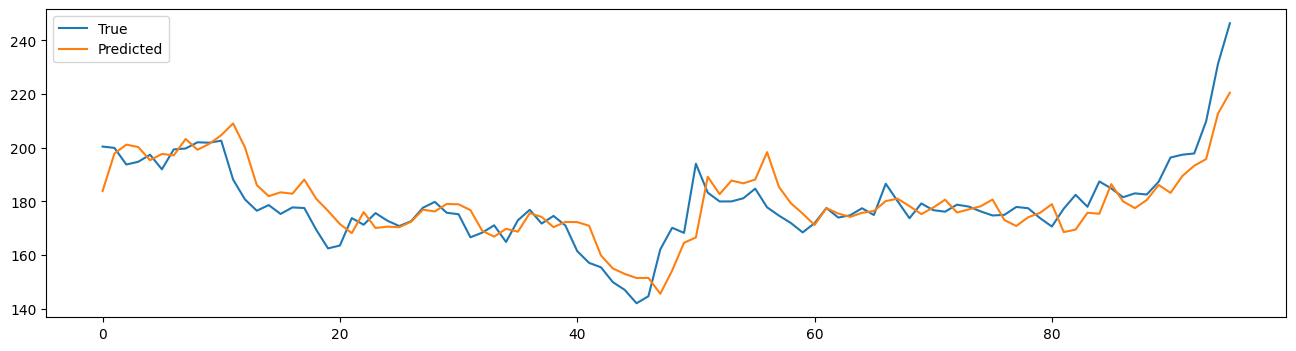

In [96]:
plt.plot(y_test_inv, label='True')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()